<a href="https://colab.research.google.com/github/berberberk/timl-fs-2024/blob/main/TIML5_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](https://fooddryingoven.com/wp-content/uploads/2019/05/dried-grapes.jpg)

In [7]:
#!pip install catboost

In [20]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [9]:

# Загрузка данных
path = '/content/Raisin_Dataset.xlsx'

data = pd.read_excel(path)
data.head()
# Проверка данных
print("Первые строки данных:")
print(data.head())

Первые строки данных:
    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  


In [10]:

# Проверка на пропуски
print("\nПроверка на пропущенные значения:")
print(data.isnull().sum())


Проверка на пропущенные значения:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64


In [11]:

# Кодирование целевой переменной (LabelEncoder)
le = LabelEncoder()
data['Class'] = le.fit_transform(data['Class'])  # Преобразуем классы в 0 и 1

# Разделение на признаки и целевую переменную
X = data.drop(columns='Class')
y = data['Class']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("\nРазмеры выборок:")
print(f"Обучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}")



Размеры выборок:
Обучающая выборка: (630, 7), Тестовая выборка: (270, 7)


In [12]:
# Инициализация и обучение дерева решений
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Предсказание и оценка
y_pred_tree = tree_clf.predict(X_test)
print("\nРезультаты модели 'Дерево решений':")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("F1-Score:", f1_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))



Результаты модели 'Дерево решений':
Accuracy: 0.825925925925926
F1-Score: 0.833922261484099
Confusion Matrix:
 [[105  30]
 [ 17 118]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       135
           1       0.80      0.87      0.83       135

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270



In [13]:
# Определение параметров для подбора
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_tree = grid_search.best_estimator_
print("\nЛучшие параметры для дерева решений:", grid_search.best_params_)

# Предсказание с лучшей моделью
y_pred_best_tree = best_tree.predict(X_test)
print("Accuracy (GridSearch):", accuracy_score(y_test, y_pred_best_tree))
print("F1-Score (GridSearch):", f1_score(y_test, y_pred_best_tree))



Лучшие параметры для дерева решений: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy (GridSearch): 0.8333333333333334
F1-Score (GridSearch): 0.8387096774193549


In [15]:
from sklearn.ensemble import BaggingClassifier

# Бэггинг с базовым классификатором - деревом решений
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred_bagging = bagging_clf.predict(X_test)
print("\nРезультаты модели 'Бэггинг':")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("F1-Score:", f1_score(y_test, y_pred_bagging))



Результаты модели 'Бэггинг':
Accuracy: 0.837037037037037
F1-Score: 0.8472222222222222


In [16]:
# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("\nРезультаты модели 'XGBoost':")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))

# CatBoost
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)

y_pred_cat = cat_clf.predict(X_test)
print("\nРезультаты модели 'CatBoost':")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("F1-Score:", f1_score(y_test, y_pred_cat))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:05:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Результаты модели 'XGBoost':
Accuracy: 0.8333333333333334
F1-Score: 0.8442906574394463

Результаты модели 'CatBoost':
Accuracy: 0.837037037037037
F1-Score: 0.8461538461538461


In [21]:
from sklearn.ensemble import StackingClassifier

# Определение базовых моделей для стекинга
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))
]

# Модель стекинга с логистической регрессией на выходе
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_clf.fit(X_train, y_train)

y_pred_stack = stack_clf.predict(X_test)
print("\nРезультаты модели 'Стекинг':")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("F1-Score:", f1_score(y_test, y_pred_stack))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:07:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:07:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:07:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Результаты модели 'Стекинг':
Accuracy: 0.8333333333333334
F1-Score: 0.845360824742268


In [22]:
print("\nСравнение моделей по F1-Score:")
print(f"Дерево решений: {f1_score(y_test, y_pred_best_tree):.3f}")
print(f"Бэггинг: {f1_score(y_test, y_pred_bagging):.3f}")
print(f"XGBoost: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"CatBoost: {f1_score(y_test, y_pred_cat):.3f}")
print(f"Стекинг: {f1_score(y_test, y_pred_stack):.3f}")



Сравнение моделей по F1-Score:
Дерево решений: 0.839
Бэггинг: 0.847
XGBoost: 0.844
CatBoost: 0.846
Стекинг: 0.845


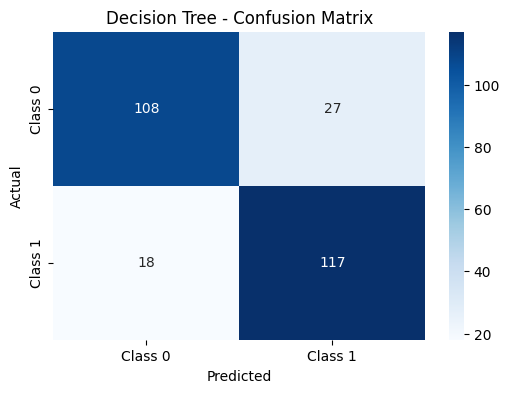

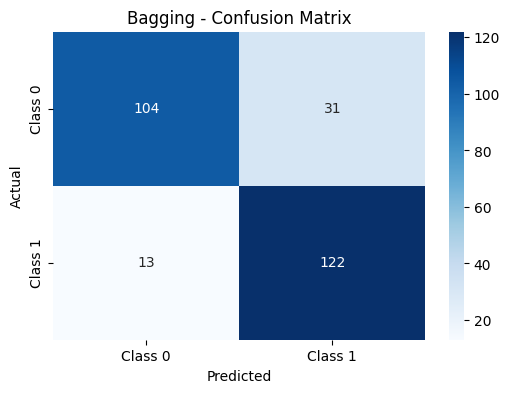

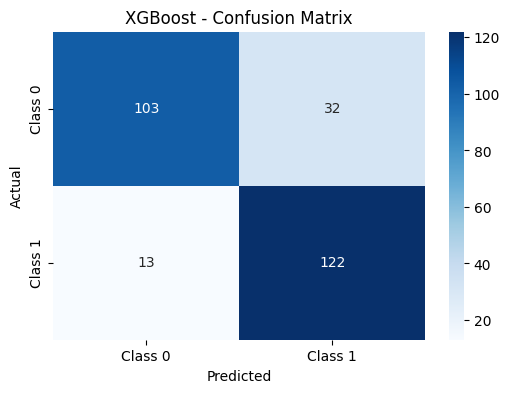

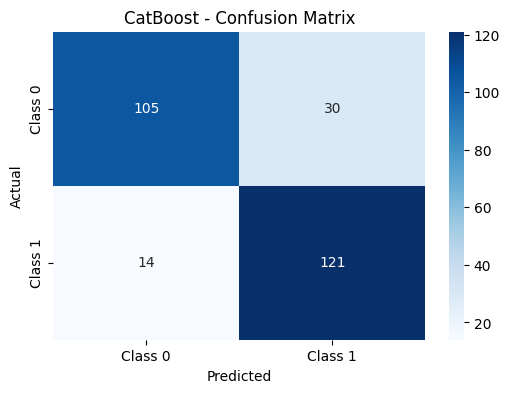

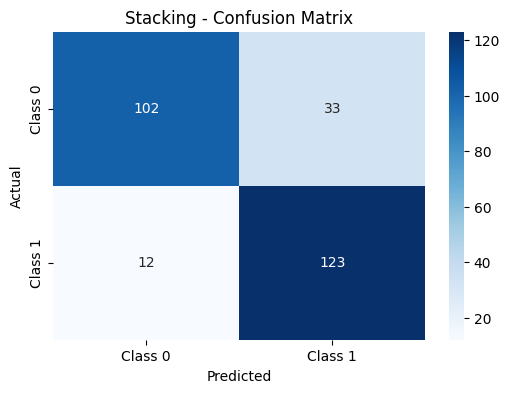

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Функция для визуализации матрицы ошибок
def plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Визуализация для каждой модели
plot_confusion_matrix(y_test, y_pred_best_tree, "Decision Tree - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_bagging, "Bagging - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_cat, "CatBoost - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_stack, "Stacking - Confusion Matrix")
